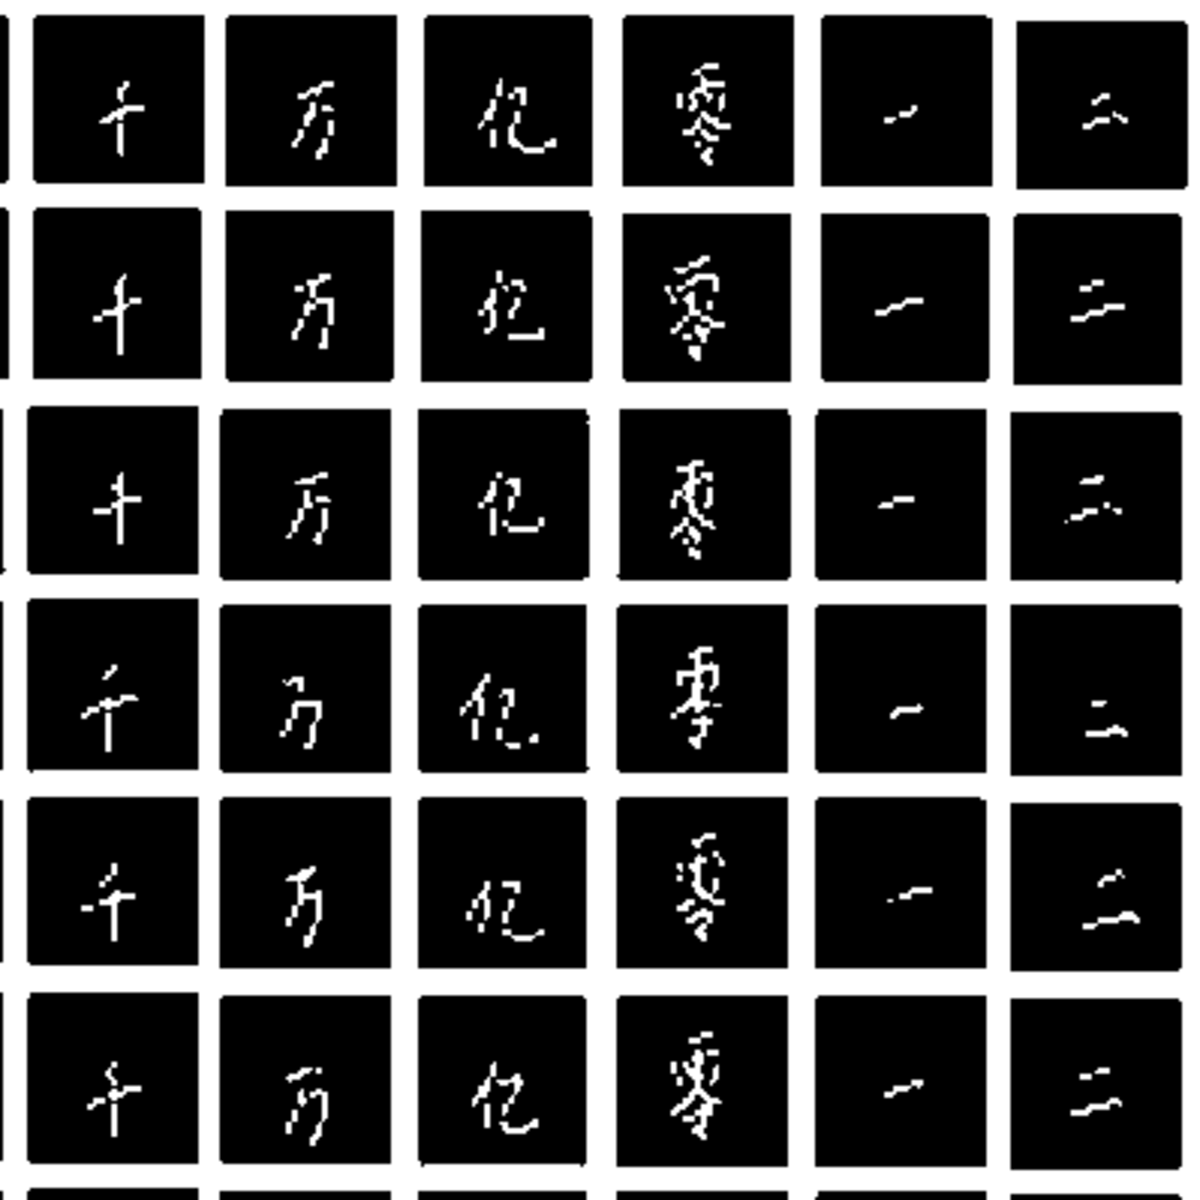

<img height = "10">

## This is an attempt to classify the chinese characters of 1 to 10, 100s, 1,000s, 10,000s, and millions with TensorFlow Keras. The data is very clean, so there isn't much wrangling to perform, thus I had the extra effort/time to perform 2 different type of models. One with SeperableConv2D & Conv2D, and another purely Conv2D, mainly to see if the SeperableConv2D actually makes a difference to performance. The final best model is the latter model. Nonetheless, this does not justify that SeperableConv2D does not make any difference, as there are cases where it performed far better. An example would be the application onto Medical Imaging that I have come across on Kaggle.

### Content

- <a href='#1'>Packages</a>
- <a href='#2'>Data Loading</a>
- <a href='#3'>Analysis</a>
- <a href='#4'>Data Preparation</a>
- <a href='#5'>Model Structuring</a>
- <a href='#6'>Model 1: Conv2D & SeperableConv2D with BatchNormalization</a>
- <a href='#7'>Model 2: Conv2D with BatchNormalization</a>
- <a href='#8'>Check Test Accuracy</a>

## <a id='1'>Packages</a>

In [2]:
import os
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import random
import skimage

# print(os.listdir("../input"))
# print(os.listdir("../input/chinese-mnist/"))

## <a id='2'>Data Loading</a>

In [2]:
dataframe = pd.read_csv("../input/chinese-mnist/chinese_mnist.csv", low_memory = False)
dataframe.head()

suite_id  sample_id  code  value character
0         1          1    10      9         九
1         1         10    10      9         九
2         1          2    10      9         九
3         1          3    10      9         九
4         1          4    10      9         九

## <a id='3'>Analysis</a>

In [3]:
dataframe.sample(10)

suite_id  sample_id  code      value character
6605         63          5     1          0         零
5218         28          8    15  100000000         亿
1646         67          6    11         10         十
4158         22          8    14      10000         万
11571        60         10     6          5         五
9430         48          1     4          3         三
159          22          9    10          9         九
6569          6          9     1          0         零
795          80          5    10          9         九
13537        57          7     8          7         七

In [4]:
print("sample_id:", dataframe.sample_id.unique())
print("code:", dataframe.code.unique())
print("character:", dataframe.character.unique()) 
print("suite_id:", dataframe.suite_id.unique())

sample_id: [ 1 10  2  3  4  5  6  7  8  9]
code: [10 11 12 13 14 15  1  2  3  4  5  6  7  8  9]
character: ['九' '十' '百' '千' '万' '亿' '零' '一' '二' '三' '四' '五' '六' '七' '八']
suite_id: [  1  10 100  11  12  13  14  15  16  17  18  19   2  20  21  22  23  24
  25  26  27  28  29   3  30  31  32  33  34  35  36  37  38  39   4  40
  41  42  43  44  45  46  47  48  49   5  50  51  52  53  54  55  56  57
  58  59   6  60  61  62  63  64  65  66  67  68  69   7  70  71  72  73
  74  75  76  77  78  79   8  80  81  82  83  84  85  86  87  88  89   9
  90  91  92  93  94  95  96  97  98  99]


code:
- 1 = 零 = zero
- 2 = 一 = one
- 3 = 二 = two
- 4 = 三 = three
- 5 = 四 = four
- 6 = 五 = five
- 7 = 六 = six
- 8 = 七 = seven
- 9 = 八 = eight
- 10 = 九 = nine
- 11 = 十 = tens
- 12 = 百 = hundred
- 13 = 千 = thousand
- 14 = 万 = million
- 15 = 亿 = billion


In [5]:
dataframe.isnull().sum()

suite_id     0
sample_id    0
code         0
value        0
character    0
dtype: int64

In [6]:
# how many image files have we got
print("No. of rows in dataframe:", dataframe.shape[0]) 
print("No. of Image files we have:", len(os.listdir("../input/chinese-mnist/data/data/")))
print("Example file:", random.choice(os.listdir("../input/chinese-mnist/data/data/")))
print("The files are named by the order of: input_(suite_id)_(sample_id)_(code).jpg")

No. of rows in dataframe: 15000
No. of Image files we have: 15000
Example file: input_44_3_1.jpg
The files are named by the order of: input_(suite_id)_(sample_id)_(code).jpg


In [7]:
# Matchin image names
def file_path_col(df):
    
    file_path = f"input_{df[0]}_{df[1]}_{df[2]}.jpg" 
    #This will return a column that has the image_file name as the data file, i.e. input_1_1_10.jpg
    
    return file_path

## <a id='4'>Data Preparation</a>

In [8]:
# Create file_path column
dataframe["file_path"] = dataframe.apply(file_path_col, axis = 1)
dataframe.head()

suite_id  sample_id  code  value character          file_path
0         1          1    10      9         九   input_1_1_10.jpg
1         1         10    10      9         九  input_1_10_10.jpg
2         1          2    10      9         九   input_1_2_10.jpg
3         1          3    10      9         九   input_1_3_10.jpg
4         1          4    10      9         九   input_1_4_10.jpg

In [9]:
image_files = os.listdir("../input/chinese-mnist/data/data/")

In [10]:
# Check matching files
file_paths = list(dataframe.file_path)
print("Number of matches: {}".format(len(set(file_paths).intersection(image_files))))
# Intersection offers the number of similarities between two items. Can be used on dataframe columns/lists.

Number of matches: 15000


In [11]:
import skimage.io
import skimage.transform


# Obtaining the image sizes
def read_image_size(file_name):
    image = skimage.io.imread("../input/chinese-mnist/data/data/" + file_name)
    return list(image.shape)

In [12]:
m = np.stack(dataframe.file_path.apply(read_image_size))
temp_df = pd.DataFrame(m, columns = ["width", "height"])
temp_df.head(2)

width  height
0     64      64
1     64      64

In [13]:
print(temp_df.shape[0])
dataframe = pd.concat([dataframe, temp_df], axis = 1, sort = False)
dataframe.head(5)

15000


suite_id  sample_id  code  value character          file_path  width  \
0         1          1    10      9         九   input_1_1_10.jpg     64   
1         1         10    10      9         九  input_1_10_10.jpg     64   
2         1          2    10      9         九   input_1_2_10.jpg     64   
3         1          3    10      9         九   input_1_3_10.jpg     64   
4         1          4    10      9         九   input_1_4_10.jpg     64   

   height  
0      64  
1      64  
2      64  
3      64  
4      64

### Preparing train/test/valid set

In [14]:
from sklearn.model_selection import train_test_split
# 1. Train and Test set
train_df, test_df = train_test_split(dataframe, 
                                     test_size = 0.2,
                                     random_state = 42,
                                     shuffle = True,
                                     stratify = dataframe.code.values)

In [15]:
# 2. Train and Val
train_df, val_df = train_test_split(train_df, 
                                    test_size = 0.2,
                                    random_state = 42,
                                    shuffle = True,
                                    stratify = train_df.code.values)

In [16]:
print("Training set observations:", train_df.shape[0],
     "\nValidation set observations:", val_df.shape[0],
     "\nTesting set observations:", test_df.shape[0])

Training set observations: 9600 
Validation set observations: 2400 
Testing set observations: 3000


## <a id='5'>Model Structuring</a>

In [17]:
def read_image(file_paths):
    image = skimage.io.imread("../input/chinese-mnist/data/data/" + file_paths)
    image = skimage.transform.resize(image, (64, 64, 1),
                                     mode = "reflect") # THe mode parameter determines how the array borders are handled.
    
    return image[:, :, :]


#For what exactly does mode do, refer to:
#https://github.com/scikit-image/scikit-image/issues/3294

In [18]:
image = skimage.io.imread("../input/chinese-mnist/data/data/" + dataframe.file_path[10])
print(image.shape)
image = skimage.transform.resize(image, (64, 64, 1), mode = "reflect")
print(image.shape)

(64, 64)
(64, 64, 1)


In [19]:
train_df.head()

suite_id  sample_id  code  value character           file_path  width  \
7822         83          2     2      1         一    input_83_2_2.jpg     64   
4095         17          5    14  10000         万   input_17_5_14.jpg     64   
4585         61          5    14  10000         万   input_61_5_14.jpg     64   
131          20         10    10      9         九  input_20_10_10.jpg     64   
12667        69          7     7      6         六    input_69_7_7.jpg     64   

       height  
7822       64  
4095       64  
4585       64  
131        64  
12667      64

In [20]:
# One hot encoder, but in 15 classes
def character_encoder(df, var = "character"):
    X = np.stack(df["file_path"].apply(read_image))
    y = pd.get_dummies(df[var], drop_first = False) #drop_first default is already at False fyi
    # For what pd.get_dummies does, refer: https://stackoverflow.com/questions/36285155/pandas-get-dummies
    return X, y

In [21]:
X_train, y_train = character_encoder(train_df)
X_val, y_val = character_encoder(val_df)
X_test, y_test = character_encoder(test_df)

print(X_train.shape, ",", y_train.shape)
print(X_val.shape, ",", y_val.shape)
print(X_test.shape, ",", y_test.shape)

(9600, 64, 64, 1) , (9600, 15)
(2400, 64, 64, 1) , (2400, 15)
(3000, 64, 64, 1) , (3000, 15)


In [22]:
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, LearningRateScheduler
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import cv2
from keras import backend as K
import imgaug as aug
#color = sns.color_palette()
%matplotlib inline

In [23]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# Set the seed for hash based operations in python
os.environ['PYTHONHASHSEED'] = '0'

# Set the numpy seed
np.random.seed(111)

# Disable multi-threading in tensorflow ops
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

# Set the random seed in tensorflow at graph level
tf.set_random_seed(111)

# Define a tensorflow session with above session configs
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)

# Set the session in keras
tf.keras.backend.set_session(sess)

# Make the augmentation sequence deterministic
aug.seed(111)

## <a id='6'>Model 1: Conv2D & SeperableConv2D with BatchNormalization</a>


In [24]:
def build_model():
    input_img = Input(shape = (64, 64, 1), name = "ImageInput")
    x = Conv2D(16,kernel_size = (3, 3), activation = "relu", padding = "same", name = "Conv1_1")(input_img)
    x = Conv2D(16,kernel_size = (3, 3) , activation = "relu", padding = "same", name = "Conv1_2")(x)
    x = MaxPooling2D((2, 2), name = "pool1")(x)
    
    x = Conv2D(32, (3, 3), activation = "relu", padding = "same", name = "Conv2_1")(x)
    x = Conv2D(32, (3, 3), activation = "relu", padding = "same", name = "Conv2_2")(x)
    x = MaxPooling2D((2, 2), name = "pool2")(x)
    
    x = Conv2D(64, (3, 3), activation = "relu", padding = "same", name = "Conv3_1")(x)
    x = BatchNormalization(name = "bn1")(x)
    x = SeparableConv2D(64, (3, 3), activation = "relu", padding = "same", name = "Conv3_2")(x)
    x = BatchNormalization(name = "bn2")(x)
    x = MaxPooling2D((2, 2), name = "pool3")(x)
    
    x = SeparableConv2D(128, (3, 3), activation = "relu", padding = "same", name = "Conv4_1")(x)
    x = BatchNormalization(name = "bn3")(x)
    x = SeparableConv2D(128, (3, 3), activation = "relu", padding = "same", name = "Conv4_2")(x)
    x = BatchNormalization(name = "bn4")(x)
    x = MaxPooling2D((2, 2), name = "pool4")(x)
    
    x = Flatten(name = "flatten")(x)
    x = Dense(1024, activation = "relu", name = "fc1")(x)
    x = Dropout(0.7, name = "dp1")(x)
    x = Dense(512, activation = "relu", name = "fc2")(x) 
    x = Dropout(0.5, name = "dp2")(x)
    x = Dense(15, activation = "softmax", name = "fc3")(x)
    
    model = Model(inputs = input_img, outputs = x)
    return model

In [25]:
model = build_model()
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      [(None, 64, 64, 1)]       0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 64, 64, 16)        160       
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 64, 64, 16)        2320      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 32, 32, 16)        0         
_________________________________________________________________
Conv2_1 (Conv2D)             (None, 32, 32, 32)        4640      
_________________________________________________________________
Conv2_2 (Conv2D)             (None, 32, 32, 32)        9248      
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 16, 16, 32)       

In [26]:
BATCH_SIZE = 32
NO_EPOCHS = 50
DROPOUT_RATIO = 0.5
PATIENCE = 5
VERBOSE = 1

In [27]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.99 ** (x + NO_EPOCHS))
es = EarlyStopping(monitor = "loss", patience = PATIENCE, verbose = VERBOSE)
cp = ModelCheckpoint("best_model.h5", monitor = "val_accuracy", verbose = VERBOSE,
                     save_best_only = True, save_weights_only = True)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer="adam")

In [28]:
history = model.fit(X_train, y_train,
                   batch_size = BATCH_SIZE,
                   epochs = NO_EPOCHS,
                   verbose = 1, 
                   validation_data = (X_val, y_val),
                   callbacks = [es, cp, annealer])

Train on 9600 samples, validate on 2400 samples
Epoch 1/50
9600/9600 [==============================] - 131s 14ms/sample - loss: 2.0025 - acc: 0.3811 - val_loss: 2.8312 - val_acc: 0.0667
Epoch 2/50
9600/9600 [==============================] - 130s 14ms/sample - loss: 0.6718 - acc: 0.7714 - val_loss: 2.6994 - val_acc: 0.1912
Epoch 3/50
9600/9600 [==============================] - 131s 14ms/sample - loss: 0.3584 - acc: 0.8876 - val_loss: 0.2366 - val_acc: 0.9225
Epoch 4/50
9600/9600 [==============================] - 130s 14ms/sample - loss: 0.2082 - acc: 0.9379 - val_loss: 0.6429 - val_acc: 0.8000
Epoch 5/50
9600/9600 [==============================] - 131s 14ms/sample - loss: 0.1876 - acc: 0.9435 - val_loss: 0.0931 - val_acc: 0.9688
Epoch 6/50
9600/9600 [==============================] - 131s 14ms/sample - loss: 0.1203 - acc: 0.9639 - val_loss: 3.1297 - val_acc: 0.4762
Epoch 7/50
9600/9600 [==============================] - 132s 14ms/sample - loss: 0.1110 - acc: 0.9668 - val_loss: 1.31

In [29]:
import seaborn as sns
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import scipy

In [30]:
def create_trace(x,y,ylabel,color):
        trace = go.Scatter(
            x = x,y = y,
            name=ylabel,
            marker=dict(color=color),
            mode = "markers+lines",
            text=x
        )
        return trace
    
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['acc']
    val_acc = hist['val_acc']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = list(range(1,len(acc)+1))
    #define the traces
    trace_ta = create_trace(epochs,acc,"Training accuracy", "Green")
    trace_va = create_trace(epochs,val_acc,"Validation accuracy", "Red")
    trace_tl = create_trace(epochs,loss,"Training loss", "Blue")
    trace_vl = create_trace(epochs,val_loss,"Validation loss", "Magenta")
    fig = tools.make_subplots(rows=1,cols=2, subplot_titles=('Training and validation accuracy',
                                                             'Training and validation loss'))
    #add traces to the figure
    fig.append_trace(trace_ta,1,1)
    fig.append_trace(trace_va,1,1)
    fig.append_trace(trace_tl,1,2)
    fig.append_trace(trace_vl,1,2)
    #set the layout for the figure
    fig['layout']['xaxis'].update(title = 'Epoch')
    fig['layout']['xaxis2'].update(title = 'Epoch')
    fig['layout']['yaxis'].update(title = 'Accuracy', range=[0,1])
    fig['layout']['yaxis2'].update(title = 'Loss', range=[0,1])
    #plot
    iplot(fig, filename='accuracy-loss')

plot_accuracy_and_loss(history)

/opt/conda/lib/python3.7/site-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [31]:
performance = model.evaluate(X_test, y_test, verbose = 0)
print("Test Loss:", performance[0])
print("Test Accuracy:", performance[1])

Test Loss: 0.18404036069886448
Test Accuracy: 0.974


## <a id='7'>Model 2: Conv2D with BatchNormalization</a>

In [32]:
def build_model2():
    input_img = Input(shape = (64, 64, 1), name = "ImageInput")
    x = Conv2D(16,kernel_size = (3, 3), activation = "relu", padding = "same", name = "Conv1_1")(input_img)
    x = Conv2D(16,kernel_size = (3, 3) , activation = "relu", padding = "same", name = "Conv1_2")(x)
    x = MaxPooling2D((2, 2), name = "pool1")(x)
    x = Dropout(0.7, name = "dp1")(x)
    
    x = Conv2D(32, (3, 3), activation = "relu", padding = "same", name = "Conv2_1")(x)
    x = Conv2D(32, (3, 3), activation = "relu", padding = "same", name = "Conv2_2")(x)
    x = MaxPooling2D((2, 2), name = "pool2")(x)
    
    x = Conv2D(64, (3, 3), activation = "relu", padding = "same", name = "Conv3_1")(x)
    x = BatchNormalization(name = "bn1")(x)
    x = Conv2D(64, (3, 3), activation = "relu", padding = "same", name = "Conv3_2")(x)
    x = BatchNormalization(name = "bn2")(x)
    x = MaxPooling2D((2, 2), name = "pool3")(x)
    x = Dropout(0.5, name = "dp2")(x)
    
    x = Conv2D(128, (3, 3), activation = "relu", padding = "same", name = "Conv4_1")(x)
    x = BatchNormalization(name = "bn3")(x)
    x = Conv2D(128, (3, 3), activation = "relu", padding = "same", name = "Conv4_2")(x)
    x = BatchNormalization(name = "bn4")(x)
    x = MaxPooling2D((2, 2), name = "pool4")(x)
    
    x = Flatten(name = "flatten")(x)
    x = Dense(1024, activation = "relu", name = "fc1")(x)
    #x = Dropout(0.7, name = "dp1")(x)
    x = Dense(512, activation = "relu", name = "fc2")(x) 
    x = Dropout(0.5, name = "dp3")(x)
    x = Dense(15, activation = "softmax", name = "fc3")(x)
    
    model = Model(inputs = input_img, outputs = x)
    return model

In [33]:
model2 = build_model2()
model2.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      [(None, 64, 64, 1)]       0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 64, 64, 16)        160       
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 64, 64, 16)        2320      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 32, 32, 16)        0         
_________________________________________________________________
dp1 (Dropout)                (None, 32, 32, 16)        0         
_________________________________________________________________
Conv2_1 (Conv2D)             (None, 32, 32, 32)        4640      
_________________________________________________________________
Conv2_2 (Conv2D)             (None, 32, 32, 32)       

In [34]:
model2.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer="adam")
history2 = model2.fit(X_train, y_train,
                   batch_size = BATCH_SIZE,
                   epochs = NO_EPOCHS,
                   verbose = 1, 
                   validation_data = (X_val, y_val),
                   callbacks = [es, cp, annealer])

Train on 9600 samples, validate on 2400 samples
Epoch 1/50
9600/9600 [==============================] - 165s 17ms/sample - loss: 1.7435 - acc: 0.4277 - val_loss: 9.1263 - val_acc: 0.0667
Epoch 2/50
9600/9600 [==============================] - 164s 17ms/sample - loss: 0.6489 - acc: 0.7694 - val_loss: 1.0150 - val_acc: 0.6667
Epoch 3/50
9600/9600 [==============================] - 166s 17ms/sample - loss: 0.3798 - acc: 0.8698 - val_loss: 0.3121 - val_acc: 0.8871
Epoch 4/50
9600/9600 [==============================] - 165s 17ms/sample - loss: 0.2741 - acc: 0.9108 - val_loss: 0.2337 - val_acc: 0.9200
Epoch 5/50
9600/9600 [==============================] - 164s 17ms/sample - loss: 0.2377 - acc: 0.9223 - val_loss: 1.2183 - val_acc: 0.6900
Epoch 6/50
9600/9600 [==============================] - 165s 17ms/sample - loss: 0.1817 - acc: 0.9402 - val_loss: 0.2505 - val_acc: 0.9112
Epoch 7/50
9600/9600 [==============================] - 164s 17ms/sample - loss: 0.1536 - acc: 0.9520 - val_loss: 2.25

In [35]:
plot_accuracy_and_loss(history2)

In [36]:
score2 = model2.evaluate(X_test, y_test, verbose = 0)
print("Test Loss:", score2[0],
      "/nTest accuracy:", score2[1])

Test Loss: 0.3824016534735759 /nTest accuracy: 0.916


## <a id='8'>Check Test Accuracy for each Class</a>
below function is referenced from [here][1]

[1]: https://www.kaggle.com/gpreda/tensorflow-keras-gpu-for-chinese-mnist-prediction#Prepare-the-data-analysis

In [37]:
from sklearn import metrics

In [38]:
def test_accuracy_report(model):
    predicted = model.predict(X_test)
    test_predicted = np.argmax(predicted, axis=1)
    test_truth = np.argmax(y_test.values, axis=1)
    print(metrics.classification_report(test_truth, test_predicted, target_names=y_test.columns)) 
    test_res = model.evaluate(X_test, y_test.values, verbose=0)
    print('Loss function: %s, accuracy:' % test_res[0], test_res[1])

In [39]:
test_accuracy_report(model2)

              precision    recall  f1-score   support

           一       1.00      1.00      1.00       200
           七       0.96      0.96      0.96       200
           万       0.99      0.98      0.98       200
           三       0.96      0.99      0.98       200
           九       0.98      0.77      0.86       200
           二       0.98      0.99      0.99       200
           五       0.91      0.99      0.95       200
           亿       0.86      1.00      0.92       200
           八       1.00      0.95      0.97       200
           六       0.98      0.98      0.98       200
           十       1.00      0.41      0.58       200
           千       0.63      1.00      0.78       200
           四       0.99      0.96      0.98       200
           百       1.00      0.74      0.85       200
           零       0.79      1.00      0.88       200

    accuracy                           0.92      3000
   macro avg       0.94      0.92      0.91      3000
weighted avg       0.94   

In [40]:
#optimal_model = model2
#optimal_model.load_weights("best_model.h5")
#optimal_score = model_optimal.evaluate(X_test, y_test, verbose = 0)
#print("Optimal Loss: ", optimal_score[0],
     #"\nOptimal Accuracy: ", optimal_score[1])